# Setup and utils

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import json, copy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata
import math
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------ MODEL UTILS ----------------------------------------------
class CustomCNN(nn.Module):
    def __init__(self, output_dim, depth, num_channels, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=math.floor(kernel_size/2)))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            # input_dim = (input_dim - kernel_size + 2 * math.floor(kernel_size/2)) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and (i+1) % depth == 0:
                setattr(self, f"pool{i}", nn.AvgPool2d(2, 2))
                # input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        # flattened_size = in_channels * input_dim * input_dim
        self.calculate_to_linear_size()

        # Add one fully connected layers for classification
        self.fc = nn.Linear(self._to_linear, output_dim)

    # calculate the input dimensions to the fully-connecting layer by forwarding a dummy input
    def calculate_to_linear_size(self):
        x = torch.zeros(1, 1, 28, 28)
        for layer_name, layer in self.named_children():
            # Process the input tensor through convolutional and activation layers
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            # Process the input tensor through pooling layers if they exist
            elif "pool" in layer_name:
                x = layer(x)
            # If reached fully connected layers, break the loop
            elif isinstance(layer, nn.Linear):
                break
        self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        # Iterate over each module in the CustomCNN class
        for layer_name, layer in self.named_children():
            # Process the input tensor through convolutional and activation layers
            if "conv" in layer_name or "act" in layer_name:
                x = layer(x)
            # Process the input tensor through pooling layers if they exist
            elif "pool" in layer_name:
                x = layer(x)
            # If reached fully connected layers, break the loop
            elif isinstance(layer, nn.Linear):
                break

        x = x.view(-1, self._to_linear) # Flatten
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

def generate_cnn(params, output_dim):
    model = CustomCNN(output_dim, params['depth'], params['width'], params['activation_function'], params['kernel_size'], params['use_pooling'])
    return model

class Trainer:
    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """
    def __init__(self, model, dataloader, lr, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        # optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

def cut_custom_cnn_model(model, cut_point, params, output_dim):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """

    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if params["freeze"]:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if params["reinit"]:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            layer.reset_parameters()
            """
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
            """

    """# if reinit_both_dense: reinit the one before the last one too
    if params["reinit_both_dense"]:
        new_model.fc_1.reset_parameters()"""

    # reinit the final dense layer anyway
    # new_model.fc.reset_parameters()

    new_model.fc = nn.Linear(new_model._to_linear, output_dim)
    
    return new_model

# --------------------------------- DATA UTILS -----------------------------------
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

"""class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)"""

class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, selected_classes):
        self.dataset = dataset
        self.label_encoder = LabelEncoder()
        
        # Fit label encoder on the selected classes
        self.label_encoder.fit(selected_classes)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        
        # Transform the label using the fitted label encoder
        label = self.label_encoder.transform([label])[0]
        
        return data, label

    def __len__(self):
        return len(self.dataset)

class TransferLearningFashionMNIST(object):
    """
    Prepares the FashionMNIST dataset for transfer learning, dividing it into pretraining and fine-tuning datasets.

    Parameters:
    - batch_size (int): Batch size for data loaders.
    - input_dim (int): The dimensionality of the input data.
    - val_split (float): The proportion of validation data.
    - num_workers (int): Number of workers for data loaders.
    - seed (int): Seed for random operations.
    """
    def __init__(self, batch_size, params):
        self.pre_train_classes = params["pre_train_classes"]
        self.fine_tune_classes = params['fine_tune_classes']

        # we also relabel the samples for both the pretrain and the fine-tune datasets, 
        # to make sure everything is correct [0,N] -usign sklearn OrdinalEncoder to be more robust
        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return RelabeledSubset(torch.utils.data.Subset(dataset, indices), classes)

        fashion_train_data = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(fashion_train_data, params['pre_train_classes'])
        finetune_train_data = filter_dataset(fashion_train_data, params['fine_tune_classes'])

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(params['val_split'] * pretrain_len)
        finetune_val_len = int(params['val_split'] * finetune_len)
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(params['generate_dataset_seed']))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(params['generate_dataset_seed']))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=params['num_workers'])
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        """# Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)"""

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=params['num_workers'])
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        fashion_test_data = datasets.FashionMNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(fashion_test_data, params['pre_train_classes'])
        finetune_test_data = filter_dataset(fashion_test_data, params['fine_tune_classes'])

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(fashion_test_data, batch_size=batch_size, shuffle=False, num_workers=params['num_workers'])

class TransferLearningWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningObj, phase):
        """
        Initializes the TransferLearningrapper object.

        Parameters:
        - transferLearningObj: An instance of the TransferLearningMNIST or TransferLearningFashionMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningObj = transferLearningObj
        # self.phase = phase
        # self.input_dim = self.transferLearningMNISTObj.input_dim
        # self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningObj.pretrain_train_loader
            self.val_loader = self.transferLearningObj.pretrain_val_loader
            self.test_loader = self.transferLearningObj.pretrain_test_loader
            self.output_dim = len(self.transferLearningObj.pre_train_classes)
        elif phase == 'finetune':
            self.train_loader = self.transferLearningObj.finetune_train_loader
            self.val_loader = self.transferLearningObj.finetune_val_loader
            self.test_loader = self.transferLearningObj.finetune_test_loader
            self.output_dim = len(self.transferLearningObj.fine_tune_classes)
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase
    
def check_class_distribution(loader, expected_classes, loader_name):
    class_counts = {label: 0 for label in expected_classes}
    for _, labels in loader:
        for label in labels:
            if label.item() in class_counts:
                class_counts[label.item()] += 1
            else:
                print(f"Unexpected class {label.item()} found in {loader_name}")
    print(f"Class distribution in {loader_name}: {class_counts}")

def test_data_loaders(tl_fashion_mnist, params):
    # Test and check data loaders
    for loader_name, loader in [
        ("Pretrain Train", tl_fashion_mnist.pretrain_train_loader),
        ("Pretrain Val", tl_fashion_mnist.pretrain_val_loader),
        ("Pretrain Test", tl_fashion_mnist.pretrain_test_loader),
        ("Finetune Train", tl_fashion_mnist.finetune_train_loader),
        ("Finetune Val", tl_fashion_mnist.finetune_val_loader),
        ("Finetune Test", tl_fashion_mnist.finetune_test_loader)
    ]:
        check_class_distribution(
            loader, 
            tl_fashion_mnist.pre_train_classes if "Pretrain" in loader_name else tl_fashion_mnist.fine_tune_classes, 
            loader_name
        )
# ------------------------------------------ PLOTTING UTILS -------------------------------------------
'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

In [1]:
# device = torch.device("cuda" if torch.cuda.is_available() else "mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NameError: name 'torch' is not defined

In [3]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
#percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3,4,5]
#seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
batch_size = 4096

## Pretraining



In [4]:
# Changes Here for the experiments
params = {
      # MODEL ARCHITECTURE PARAMS
      'depth': 5,
      'width': 30, # num channels for CNN
      # 'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 3,
      # TRAINING PARAMS
      'device': device,
      'lr_pretrain': 0.001,   
      'lr_fine_tune': 0.001,  # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_reinit': 0.001,         # CHANGE: if no layer-wise lr
      # 'lr_fine_tune_no_reinit': 0.0001,     # CHANGE: if layer-wise lr
      'num_train': 40,
      'early_stop_patience': 6,
      'save_best': False,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'batch_size':batch_size,
      # DATASET PARAMS
      'pre_train_classes': [0, 1, 2, 3, 4, 6, 8],
      'fine_tune_classes': [5, 7, 9],
        'val_split': 0.1,
      'num_workers': 0,
      'generate_dataset_seed': 42,
      # EXPERIMENT SETTING PARAMS
      'percentages':percentages,
      'use_pooling': False,   # CHANGE
      'freeze': True,         # CHANGE: freeze the conv layers before the cut
      'reinit': True,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
    }

In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

class TransferLearningWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases,
    handling different datasets for each phase.
    """
    def __init__(self, pretrain_dataset, finetune_dataset, root_dir, batch_size=64, transform=None, val_split=0.2):
        """
        Initializes the TransferLearningWrapper object.

        Parameters:
        - pretrain_dataset: Dataset class to be used for pretraining.
        - finetune_dataset: Dataset class to be used for fine-tuning.
        - root_dir: Directory where datasets will be downloaded or loaded from.
        - batch_size: Batch size for data loaders.
        - transform: Transformations to be applied to the datasets.
        - val_split: Fraction of training data to be used for validation.
        """
        if transform is None:
            transform = transforms.ToTensor()

        # Load and split datasets for training and validation
        pretrain_full = pretrain_dataset(root=root_dir, train=True, download=True, transform=transform)
        finetune_full = finetune_dataset(root=root_dir, train=True, download=True, transform=transform)

        pretrain_train_size = int((1 - val_split) * len(pretrain_full))
        pretrain_val_size = len(pretrain_full) - pretrain_train_size

        finetune_train_size = int((1 - val_split) * len(finetune_full))
        finetune_val_size = len(finetune_full) - finetune_train_size

        self.pretrain_train_dataset, self.pretrain_val_dataset = random_split(pretrain_full, [pretrain_train_size, pretrain_val_size])
        self.finetune_train_dataset, self.finetune_val_dataset = random_split(finetune_full, [finetune_train_size, finetune_val_size])

        # Create data loaders
        self.pretrain_train_loader = torch.utils.data.DataLoader(self.pretrain_train_dataset, batch_size=batch_size, shuffle=True)
        self.pretrain_val_loader = torch.utils.data.DataLoader(self.pretrain_val_dataset, batch_size=batch_size, shuffle=False)
        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_dataset(root=root_dir, train=False, download=True, transform=transform), batch_size=batch_size, shuffle=False)
        
        self.finetune_train_loader = torch.utils.data.DataLoader(self.finetune_train_dataset, batch_size=batch_size, shuffle=True)
        self.finetune_val_loader = torch.utils.data.DataLoader(self.finetune_val_dataset, batch_size=batch_size, shuffle=False)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_dataset(root=root_dir, train=False, download=True, transform=transform), batch_size=batch_size, shuffle=False)

        self.output_dim = 10

        self.update_phase('pretrain')

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.pretrain_train_loader
            self.val_loader = self.pretrain_val_loader
            self.test_loader = self.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.finetune_train_loader
            self.val_loader = self.finetune_val_loader
            self.test_loader = self.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
        return self.phase

# Example usage
root_dir = './data'  # Specify your data directory here
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataloader_wrapped = TransferLearningWrapper(datasets.FashionMNIST, datasets.MNIST, root_dir, batch_size=64, transform=transform)


In [19]:
#Create DNN model
pretrained_model = generate_cnn(params, 10)
pretrained_model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (conv3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv4): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (fc): Linear(in_features=23520, out_features=10, bias=True)
)

In [20]:
# Train and evaluate
trainer = Trainer(pretrained_model, dataloader_wrapped, params["lr_pretrain"], params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 90.03%
Validation Accuracy: 88.92%
Epoch: 1 	Training Accuracy: 92.06%
Validation Accuracy: 90.30%
Epoch: 2 	Training Accuracy: 94.10%
Validation Accuracy: 91.07%
Epoch: 3 	Training Accuracy: 95.71%
Validation Accuracy: 91.48%
Epoch: 4 	Training Accuracy: 96.65%
Validation Accuracy: 91.47%
Epoch: 5 	Training Accuracy: 97.40%
Validation Accuracy: 90.71%
Epoch: 6 	Training Accuracy: 98.15%
Validation Accuracy: 90.89%
Epoch: 7 	Training Accuracy: 98.36%
Validation Accuracy: 90.32%
Epoch: 8 	Training Accuracy: 98.83%
Validation Accuracy: 90.90%
Epoch: 9 	Training Accuracy: 99.16%
Validation Accuracy: 90.73%
Early stopping invoked.
Final Training Accuracy: 0.9571
Final Test Accuracy: 0.9136


In [50]:
pretrained_model.load_state_dict(torch.load('pretrained_models/pretrained_0.001/pretrained_model_89percent.pth'))
pretrained_model.to(device)

RuntimeError: Error(s) in loading state_dict for CustomCNN:
	size mismatch for fc.weight: copying a param with shape torch.Size([7, 23520]) from checkpoint, the shape in current model is torch.Size([3, 23520]).
	size mismatch for fc.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([3]).

In [21]:
eval(pretrained_model, device, dataloader_wrapped.test_loader, debug=True, classification_report_flag=True, is_cnn=True)


Average loss: 0.2517, Accuracy: 9136.0/10000 (91%)

              precision    recall  f1-score   support

     Class 0       0.84      0.88      0.86      1000
     Class 1       0.99      0.98      0.98      1000
     Class 2       0.90      0.85      0.87      1000
     Class 3       0.92      0.92      0.92      1000
     Class 4       0.85      0.89      0.87      1000
     Class 5       0.98      0.98      0.98      1000
     Class 6       0.74      0.74      0.74      1000
     Class 7       0.95      0.97      0.96      1000
     Class 8       0.98      0.98      0.98      1000
     Class 9       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



0.9136

In [39]:
# save model for later use
torch.save(pretrained_model.state_dict(), 'pretrained_models/pretrained_0.001/pretrained_model_only_fashion.pth')

params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
#save params as well
with open('pretrained_models/pretrained_0.001/params.json', 'w') as fp:
    json.dump(params_tmp, fp)

## Fine-tuning Experiments

In [ ]:
# load results: to continue from a checkpoint (actually don't run)
with open('results.json', 'r') as f:
    results = json.load(f)

### Baselines (skip if it was already run)

In [42]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3]

In [43]:
results = []

In [44]:
#training of baseline, end to end, models (#trials x #percentages)

dataloader_wrapped.update_phase('finetune')

# template_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
#                      hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])

for sampled_percentage in percentages:      
    if sampled_percentage <= 0.01:
        repeats = 25
    elif sampled_percentage < 0.5:
        repeats = 20
    else:
        repeats = 5
    
    for repeat in range(repeats):
        # Print or log the sampled values for transparency
        print(f"\nSampled Percentage: {sampled_percentage}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

        # Reduce the dataset
        train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        torch.manual_seed(repeat)
        #train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed = repeat)
        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)

        # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
        params_tmp = copy.deepcopy(params)
        params_tmp["reinit"] = True
        model_new = cut_custom_cnn_model(pretrained_model, cut_point=0, params=params_tmp, output_dim=dataloader_wrapped.output_dim)
        model_new.to(device)

        # Train and evaluate
        trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
        train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
        print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

        # Store the results
        results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":-1, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc}) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Lr: 0.001, Repeat: 0


Early stopping invoked.
Training Accuracy: 0.9750, Test Accuracy: 0.6689

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9250, Test Accuracy: 0.6373

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.5902

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 0.8250, Test Accuracy: 0.6568

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 0.9500, Test Accuracy: 0.6455

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 5
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6344

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 6
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6985

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 7
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.6232

Sampled Percentage: 0.001, Lr: 0.001, Repeat: 8
Early stopping invoked.


In [45]:
results_baseline = results

In [53]:
print(results_baseline)

[{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 0, 'train_acc': 0.975, 'test_acc': 0.6689}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 1, 'train_acc': 0.925, 'test_acc': 0.6373}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.5902}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 3, 'train_acc': 0.825, 'test_acc': 0.6568}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 4, 'train_acc': 0.95, 'test_acc': 0.6455}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.6344}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.6985}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': -1, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.6232}, {'lr': 0.001, 'sampled_percentag

In [21]:
# save baseline results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results

with open(f'results_jsons/baselines_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_dummy_run.json', 'w') as f:
    json.dump(results, f)

In [24]:
#load results
with open('results_jsons/baselines_freeze_True_pool_False_lr_0.001_fat_run.json', 'r') as f:
    results_baseline = json.load(f)

# keep only the ones with cut_point = -1
results_baseline = results_baseline[1:]
results_baseline = [result for result in results_baseline if result["sampled_cut_point"] == -1]

### Fine-tuning

In [29]:
# percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1]
results = []

In [30]:
dataloader_wrapped.update_phase('finetune')

# Store results
#results = []
# Store unique combinations that have been tested: we need this if we want to test random combinations
# tested_combinations = set()

# for lr in learning_rates:
#     params["lr"] = lr
# repeating the whole thing with multiple lr and saving the results somewhere
for sampled_percentage in percentages:

    if sampled_percentage <= 0.01:
        repeats = 5
    elif sampled_percentage < 0.5:
        repeats = 3
    else:
        repeats = 1
        
    for sampled_cut_point in cuts:

        for repeat in range(repeats):
            # Add the combination to the tested set
            # tested_combinations.add((sampled_percentage, sampled_cut_point))

            # Print or log the sampled values for transparency
            print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Lr: {params['lr_fine_tune']}, Repeat: {repeat}")

            # Reduce the dataset
            train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=repeat)
            dataset_namespace_new = SimpleNamespace(train_loader=train_loader_reduced, test_loader=dataloader_wrapped.test_loader, val_loader=dataloader_wrapped.val_loader)
            torch.manual_seed(repeat) # because in the cut function we reinitialize some layers too (at least the dense layers)
            
            # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
            model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, params=params, output_dim=dataloader_wrapped.output_dim)
            model_new.to(device)
            
            # Train and evaluate
            trainer = Trainer(model_new, dataset_namespace_new, params['lr_fine_tune'], params)
            train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

            # Store the results
            results.append({"lr":params['lr_fine_tune'], "sampled_percentage":sampled_percentage, "sampled_cut_point":sampled_cut_point, "repeat":repeat, "train_acc":train_acc, "test_acc":test_acc})


Sampled Percentage: 0.005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.8412

Sampled Percentage: 0.005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.8496

Sampled Percentage: 0.005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 2
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.8348

Sampled Percentage: 0.005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 3
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.8417

Sampled Percentage: 0.005, Sampled Cut Point: 0, Lr: 0.001, Repeat: 4
Early stopping invoked.
Training Accuracy: 1.0000, Test Accuracy: 0.8550

Sampled Percentage: 0.005, Sampled Cut Point: 1, Lr: 0.001, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.9542, Test Accuracy: 0.8365

Sampled Percentage: 0.005, Sampled Cut Point: 1, Lr: 0.001, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.9875, Test Accuracy:

In [27]:
# save fine-tuning results
params_tmp = copy.deepcopy(params)
del params_tmp["device"]
params_tmp["activation_function"] = str(params_tmp["activation_function"])
results = [params_tmp] + results

with open(f'results_jsons/results_freeze_{params["freeze"]}_reinit_{params["reinit"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_dummy_run.json', 'w') as f:
    json.dump(results, f)
results = results[1:]

In [48]:
r3 = [{'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9582}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9958333333333333, 'test_acc': 0.9497}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9954166666666666, 'test_acc': 0.9498}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9995833333333334, 'test_acc': 0.9592}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.962}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9581}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9586}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9593}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9618}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9586}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9627}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9673}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9593}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.9929166666666667, 'test_acc': 0.9473}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.9945833333333334, 'test_acc': 0.9496}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.99625, 'test_acc': 0.9451}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9627}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9656}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 0.9975, 'test_acc': 0.9546}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9551}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9995833333333334, 'test_acc': 0.9502}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9572}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.958}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9566}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9582}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9644}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9991666666666666, 'test_acc': 0.9539}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9596}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.9970833333333333, 'test_acc': 0.9514}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9605}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.9995833333333334, 'test_acc': 0.9551}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 0.99875, 'test_acc': 0.9579}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.9991666666666666, 'test_acc': 0.9557}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9583}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9604}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9995833333333334, 'test_acc': 0.953}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9637}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.9995833333333334, 'test_acc': 0.959}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9601}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.9983333333333333, 'test_acc': 0.9549}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9991666666666666, 'test_acc': 0.9603}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9609}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9571}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9995833333333334, 'test_acc': 0.96}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9621}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9595}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.9995833333333334, 'test_acc': 0.9605}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9658}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9656}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9645}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.9983333333333333, 'test_acc': 0.9567}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9658}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9609}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9633}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.9991666666666666, 'test_acc': 0.9595}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9613}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9647}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9995833333333334, 'test_acc': 0.9623}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 0.99875, 'test_acc': 0.9603}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9646}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9606}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9592}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9552}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9614}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9615}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9624}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9614}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.9991666666666666, 'test_acc': 0.9592}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9604}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9635}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9621}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9645}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9577}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9587}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.9991666666666666, 'test_acc': 0.9605}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9564}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9658}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9642}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.964}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9569}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9591}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9576}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.957}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9592}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9601}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.962}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9588}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9585}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9582}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9619}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9615}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9608}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9579}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9589}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9597}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9568}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9607}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9635}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9581}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9576}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9544}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9532}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9492}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9548}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.955}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9573}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9555}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9538}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9546}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9553}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9569}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9568}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9522}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9526}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9563}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9523}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9563}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.957}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9545}, {'lr': 0.001, 'sampled_percentage': 0.05, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9554}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9979166666666667, 'test_acc': 0.9679}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.973}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9960416666666667, 'test_acc': 0.969}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9696}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9672}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.9997916666666666, 'test_acc': 0.9696}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9732}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9989583333333333, 'test_acc': 0.9704}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.972}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.972}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9722}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9718}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9724}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9702}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9716}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.9975, 'test_acc': 0.9631}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9687}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9733}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9728}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9689}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9752}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9738}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9701}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9722}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.97}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9726}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9697}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.9983333333333333, 'test_acc': 0.9701}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.9995833333333334, 'test_acc': 0.9696}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.9997916666666666, 'test_acc': 0.9699}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9728}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9743}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9723}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9711}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9685}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9694}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9689}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9739}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 0.99875, 'test_acc': 0.9683}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9714}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9997916666666666, 'test_acc': 0.9768}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9997916666666666, 'test_acc': 0.9753}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9732}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9755}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9742}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9747}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.9997916666666666, 'test_acc': 0.9745}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.973}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.99375, 'test_acc': 0.9675}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.998125, 'test_acc': 0.9715}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.999375, 'test_acc': 0.9741}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9746}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9709}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9738}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9717}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9733}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9739}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9989583333333333, 'test_acc': 0.9733}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9741}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.9997916666666666, 'test_acc': 0.9698}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9752}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9995833333333334, 'test_acc': 0.9718}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9728}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9758}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9707}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9742}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.975}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.9989583333333333, 'test_acc': 0.9696}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 0.9966666666666667, 'test_acc': 0.97}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9727}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.999375, 'test_acc': 0.9755}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9742}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9705}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 0.9995833333333334, 'test_acc': 0.9703}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9726}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9717}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9737}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9758}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9758}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9713}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9698}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9709}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.971}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9729}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9699}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9723}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9728}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9705}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9682}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9724}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.972}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9714}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9677}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9726}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9696}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.971}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9712}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9718}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9714}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9687}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9651}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9654}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9633}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9663}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9634}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9641}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9664}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9641}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9645}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9656}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.965}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.965}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9612}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9634}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9651}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9624}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9658}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9681}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9653}, {'lr': 0.001, 'sampled_percentage': 0.1, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9646}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.9991666666666666, 'test_acc': 0.9791}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9956944444444444, 'test_acc': 0.9818}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9929166666666667, 'test_acc': 0.9795}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9998611111111111, 'test_acc': 0.9838}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9827}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.9989583333333333, 'test_acc': 0.9811}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9989583333333333, 'test_acc': 0.9806}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9952083333333334, 'test_acc': 0.9788}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.9990277777777777, 'test_acc': 0.9813}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.99875, 'test_acc': 0.9826}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.9985416666666667, 'test_acc': 0.9806}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.9907638888888889, 'test_acc': 0.9776}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.9991666666666666, 'test_acc': 0.9813}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.9942361111111111, 'test_acc': 0.9789}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 0.9981944444444445, 'test_acc': 0.9799}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.9986805555555556, 'test_acc': 0.9785}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.9965277777777778, 'test_acc': 0.9812}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.9994444444444445, 'test_acc': 0.9799}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9819}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.9986805555555556, 'test_acc': 0.9787}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9997222222222222, 'test_acc': 0.9777}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.99625, 'test_acc': 0.9801}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9965972222222222, 'test_acc': 0.9794}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9821}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 0.9970833333333333, 'test_acc': 0.9803}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 0.9907638888888889, 'test_acc': 0.9795}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9980555555555556, 'test_acc': 0.9803}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.9989583333333333, 'test_acc': 0.9773}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.9958333333333333, 'test_acc': 0.979}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.9959722222222223, 'test_acc': 0.9802}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9844}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.983}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.9996527777777777, 'test_acc': 0.9796}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 0.9990972222222222, 'test_acc': 0.9783}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 0.9975, 'test_acc': 0.9808}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9975694444444444, 'test_acc': 0.9793}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.9997222222222222, 'test_acc': 0.9782}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.9975694444444444, 'test_acc': 0.982}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9835}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 0.9970138888888889, 'test_acc': 0.9806}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 0.9984027777777778, 'test_acc': 0.9812}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9992361111111111, 'test_acc': 0.9823}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9992361111111111, 'test_acc': 0.9802}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9944444444444445, 'test_acc': 0.9815}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9976388888888889, 'test_acc': 0.9813}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 0.9967361111111112, 'test_acc': 0.9823}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 0.9997222222222222, 'test_acc': 0.9849}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.996875, 'test_acc': 0.9792}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.9965277777777778, 'test_acc': 0.9817}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 0.9981944444444445, 'test_acc': 0.9824}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 0.9995833333333334, 'test_acc': 0.983}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.9948611111111111, 'test_acc': 0.9827}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.9995138888888889, 'test_acc': 0.9819}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 0.9981944444444445, 'test_acc': 0.9843}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 0.9939583333333334, 'test_acc': 0.9816}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.9990277777777777, 'test_acc': 0.9828}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9984027777777778, 'test_acc': 0.9797}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9978472222222222, 'test_acc': 0.9827}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9853}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.9980555555555556, 'test_acc': 0.9817}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9980555555555556, 'test_acc': 0.9821}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 0.9995138888888889, 'test_acc': 0.9839}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 0.9997222222222222, 'test_acc': 0.9843}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 0.9935416666666667, 'test_acc': 0.9801}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 0.9970833333333333, 'test_acc': 0.9818}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 0.9999305555555555, 'test_acc': 0.9839}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.983}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9845}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9843}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 0.9998611111111111, 'test_acc': 0.9858}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.9989583333333333, 'test_acc': 0.9827}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9855}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.9979861111111111, 'test_acc': 0.9798}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.985}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 0.9969444444444444, 'test_acc': 0.9808}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.9998611111111111, 'test_acc': 0.9799}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.999375, 'test_acc': 0.9835}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 0.9980555555555556, 'test_acc': 0.9807}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 0.9973611111111111, 'test_acc': 0.9823}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 0.9994444444444445, 'test_acc': 0.9822}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9815}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 0.9973611111111111, 'test_acc': 0.9793}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9821}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9834}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 0.9998611111111111, 'test_acc': 0.9814}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9823}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9827}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9817}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 0.9997916666666666, 'test_acc': 0.9816}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9821}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9825}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9831}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9791}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9822}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9834}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9806}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9817}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9822}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 0.9994444444444445, 'test_acc': 0.9818}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9822}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.9745}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9745}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9741}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9755}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9767}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9746}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9742}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9734}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9765}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9767}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.9759}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9766}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 0.9997916666666666, 'test_acc': 0.9722}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9757}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9745}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 0.9999305555555555, 'test_acc': 0.9739}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.9744}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 0.9996527777777777, 'test_acc': 0.9745}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9745}, {'lr': 0.001, 'sampled_percentage': 0.3, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.976}]
r2 = [{'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 0.975, 'test_acc': 0.6797}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.975, 'test_acc': 0.6073}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.693}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9, 'test_acc': 0.6305}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 0.975, 'test_acc': 0.628}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.6437}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.975, 'test_acc': 0.7047}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.6581}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.975, 'test_acc': 0.6019}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.6605}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 0.975, 'test_acc': 0.6517}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.6583}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.6568}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.689}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.6726}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.6779}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 0.975, 'test_acc': 0.6809}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.975, 'test_acc': 0.6051}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.6933}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.7188}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 0.975, 'test_acc': 0.6212}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.6218}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.6877}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.6548}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.6645}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.6624}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.6273}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.7158}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.6295}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.6566}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.6548}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.6866}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.975, 'test_acc': 0.6132}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.6507}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.7057}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.6371}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.875, 'test_acc': 0.6416}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.6822}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.7053}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.6884}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.975, 'test_acc': 0.7035}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 0.95, 'test_acc': 0.6242}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7053}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.6997}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 0.95, 'test_acc': 0.6245}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.5702}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.7304}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.6547}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.6924}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.6667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.6174}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.975, 'test_acc': 0.646}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.6712}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.6515}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.6442}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.6751}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.678}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.6314}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.6436}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.6668}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.6554}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 0.975, 'test_acc': 0.6466}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.6921}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.7004}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.7054}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.6864}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.975, 'test_acc': 0.6623}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7225}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.7047}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.5982}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.5954}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.6815}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.6226}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.6454}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.6052}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.5755}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.698}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.6764}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.6196}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.6484}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.6705}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.6624}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.6053}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.6318}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.6468}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.6534}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.975, 'test_acc': 0.6434}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.6463}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.6747}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.7013}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.7028}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.6528}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7064}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.6748}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.5927}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.5709}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.6844}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.6156}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.6451}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.6428}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.6539}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.6842}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.6431}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.6298}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.653}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.6962}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.6774}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.6046}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.6386}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.6603}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.634}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.6482}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.6433}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.6688}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.7007}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.7036}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.6556}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.6669}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.6575}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.6015}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.5683}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.6898}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.6166}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.6601}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.6349}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.6282}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.6663}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.6461}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.5938}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.644}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.6441}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.6701}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.6284}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.6634}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.6531}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.6354}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.6585}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.6485}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.6591}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.6597}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.6748}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.6667}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.6352}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.6798}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.5959}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.5626}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.6416}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.6256}, {'lr': 0.001, 'sampled_percentage': 0.001, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.6332}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.789}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.7257}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9888888888888889, 'test_acc': 0.7376}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.7637}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.774}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 0.9777777777777777, 'test_acc': 0.7713}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 0.9888888888888889, 'test_acc': 0.7935}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.6985}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.8777777777777778, 'test_acc': 0.72}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 0.9555555555555556, 'test_acc': 0.7392}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.7715}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.9444444444444444, 'test_acc': 0.7676}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.808}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 0.9555555555555556, 'test_acc': 0.797}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.7386}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 0.9777777777777777, 'test_acc': 0.78}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.77}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 0.9777777777777777, 'test_acc': 0.7527}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7528}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.7589}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 0.9888888888888889, 'test_acc': 0.7386}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.7235}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.7541}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 0.9777777777777777, 'test_acc': 0.7651}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.7835}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 0.9888888888888889, 'test_acc': 0.7973}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.731}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.9888888888888889, 'test_acc': 0.775}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.7563}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.766}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8162}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9777777777777777, 'test_acc': 0.7628}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.9777777777777777, 'test_acc': 0.7229}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.7274}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 0.9555555555555556, 'test_acc': 0.731}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 0.9888888888888889, 'test_acc': 0.8011}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.7533}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 0.9666666666666667, 'test_acc': 0.7981}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.7588}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.7463}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9888888888888889, 'test_acc': 0.7738}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.7735}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.727}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7325}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.7427}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 0.9555555555555556, 'test_acc': 0.758}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.7232}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 0.9666666666666667, 'test_acc': 0.7507}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.7403}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.8003}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7814}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 0.9777777777777777, 'test_acc': 0.7335}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.7642}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 0.9777777777777777, 'test_acc': 0.7425}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 0.9777777777777777, 'test_acc': 0.7587}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.7697}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.8044}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.9777777777777777, 'test_acc': 0.7096}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 0.9888888888888889, 'test_acc': 0.7223}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.7283}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.7661}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.9777777777777777, 'test_acc': 0.7539}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.7815}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.7598}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.743}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 0.9555555555555556, 'test_acc': 0.7735}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9888888888888889, 'test_acc': 0.7675}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.7325}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7653}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 0.9888888888888889, 'test_acc': 0.7691}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 0.9888888888888889, 'test_acc': 0.7609}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 0.9777777777777777, 'test_acc': 0.7353}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 0.9555555555555556, 'test_acc': 0.7399}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.7152}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.7799}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7348}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.7132}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.7383}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.7499}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.7592}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.7636}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.7776}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 0.9888888888888889, 'test_acc': 0.7188}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.7139}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.7278}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 0.9777777777777777, 'test_acc': 0.7581}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.781}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 0.9888888888888889, 'test_acc': 0.7787}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.7491}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.7436}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 0.9777777777777777, 'test_acc': 0.8034}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.7665}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.7502}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7853}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.786}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.7737}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.722}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.7714}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.7298}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.7463}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.7775}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.7637}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.7751}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.7541}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.76}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.7743}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.8015}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.7414}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.7239}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.7481}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.7983}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.7691}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8142}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.7598}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.7402}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8091}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 0.9888888888888889, 'test_acc': 0.7794}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.7328}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7926}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.7773}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.7883}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.7339}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.7663}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.7301}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.7786}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.761}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.7315}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.7792}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.7547}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.7598}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.7731}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.7789}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.7365}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.724}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.7727}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.7958}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.7632}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.7913}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.7691}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.7646}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8136}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.7762}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.7699}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.7758}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.7739}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.77}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.7322}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.7322}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.7498}, {'lr': 0.001, 'sampled_percentage': 0.002, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.7662}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8507}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 0.9958333333333333, 'test_acc': 0.8387}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8472}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9791666666666666, 'test_acc': 0.8501}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8316}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8339}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.8683}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9583333333333334, 'test_acc': 0.8368}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 0.9791666666666666, 'test_acc': 0.8362}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8538}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8427}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8588}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.9875, 'test_acc': 0.8376}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8678}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8506}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8377}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.842}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8404}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.8537}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8625}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8425}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8466}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.842}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 0.9708333333333333, 'test_acc': 0.8335}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 0.9958333333333333, 'test_acc': 0.8166}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8704}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 0.9916666666666667, 'test_acc': 0.8375}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 0.95, 'test_acc': 0.8385}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9541666666666667, 'test_acc': 0.8529}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.834}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8734}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 0.9958333333333333, 'test_acc': 0.8434}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 0.9625, 'test_acc': 0.837}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 0.9958333333333333, 'test_acc': 0.8426}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8725}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8754}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8504}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8369}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8673}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8426}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 0.9916666666666667, 'test_acc': 0.8533}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.9916666666666667, 'test_acc': 0.8514}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8421}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.8589}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8685}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8415}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8593}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.857}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8533}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 0.9958333333333333, 'test_acc': 0.8264}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8459}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8581}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 0.9791666666666666, 'test_acc': 0.8497}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8586}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8393}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8558}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.8631}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 0.9958333333333333, 'test_acc': 0.8487}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.8779}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8766}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8446}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 0.9958333333333333, 'test_acc': 0.8453}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8453}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8707}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8551}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8578}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 0.9791666666666666, 'test_acc': 0.8349}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8594}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.8551}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8654}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8371}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8594}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.8566}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8503}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.8598}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 0.9916666666666667, 'test_acc': 0.8327}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8455}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8348}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8579}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8443}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8589}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.8598}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8525}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.8498}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8575}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8478}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8549}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8372}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8601}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8611}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8469}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 0.9916666666666667, 'test_acc': 0.8532}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8545}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.846}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8619}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8523}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8457}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.8471}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8378}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.8267}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8625}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8785}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8641}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8727}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8609}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.857}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.8814}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8549}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.8711}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8787}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.863}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.863}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8584}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8802}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8571}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8715}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.875}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8812}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.8662}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8771}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8707}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8604}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.862}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 0.9958333333333333, 'test_acc': 0.8534}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.8817}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8606}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8694}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8742}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.8662}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8638}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.86}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.8776}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8633}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.8586}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8768}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8616}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8706}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8534}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8704}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8488}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8716}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.8717}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8756}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.867}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8779}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8593}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8667}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.854}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8698}, {'lr': 0.001, 'sampled_percentage': 0.005, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.8613}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8894}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8895}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 2, 'train_acc': 0.9916666666666667, 'test_acc': 0.8912}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 3, 'train_acc': 0.9729166666666667, 'test_acc': 0.8829}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8828}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8719}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.8916}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 7, 'train_acc': 0.9979166666666667, 'test_acc': 0.8768}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.889}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8841}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8861}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 11, 'train_acc': 0.9979166666666667, 'test_acc': 0.8909}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 12, 'train_acc': 0.975, 'test_acc': 0.8789}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8893}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8859}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8686}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.8852}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.8984}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9025}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 19, 'train_acc': 0.9875, 'test_acc': 0.8795}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8964}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.885}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.8842}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8971}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 0, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.8858}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8816}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8777}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8993}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 3, 'train_acc': 0.9979166666666667, 'test_acc': 0.8976}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8945}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9143}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9042}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.8968}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.8946}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9117}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8947}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9021}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.891}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.8999}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8774}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8878}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 16, 'train_acc': 0.9979166666666667, 'test_acc': 0.8718}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9022}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.8954}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8978}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8988}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8957}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.89}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8929}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 1, 'repeat': 24, 'train_acc': 0.9958333333333333, 'test_acc': 0.9003}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8908}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9141}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.913}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9039}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.8972}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8851}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.905}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9057}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9241}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9039}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8923}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8995}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8947}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9037}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8768}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9088}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.88}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 17, 'train_acc': 0.9979166666666667, 'test_acc': 0.8926}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9091}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9112}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.9048}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8937}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.8976}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8922}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 2, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.9095}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8789}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.8911}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.8878}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9003}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9028}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.8893}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9022}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9039}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9055}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.8955}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8891}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.8885}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.8975}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9039}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.9001}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.8851}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.8874}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.892}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9063}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.8988}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.8974}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.8904}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.8917}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.8831}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 3, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.89}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8915}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.9093}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9072}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9049}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.907}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.89}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.917}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.907}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9101}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9145}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.899}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9002}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9094}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9182}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8989}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9055}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.8997}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.904}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9101}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9086}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.9128}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.9037}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.9101}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.9075}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 4, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.917}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 0, 'train_acc': 1.0, 'test_acc': 0.8992}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 1, 'train_acc': 1.0, 'test_acc': 0.911}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 2, 'train_acc': 1.0, 'test_acc': 0.9159}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 3, 'train_acc': 1.0, 'test_acc': 0.9049}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 4, 'train_acc': 1.0, 'test_acc': 0.9122}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 5, 'train_acc': 1.0, 'test_acc': 0.9066}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 6, 'train_acc': 1.0, 'test_acc': 0.9126}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 7, 'train_acc': 1.0, 'test_acc': 0.9087}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 8, 'train_acc': 1.0, 'test_acc': 0.9012}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 9, 'train_acc': 1.0, 'test_acc': 0.9101}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 10, 'train_acc': 1.0, 'test_acc': 0.8981}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 11, 'train_acc': 1.0, 'test_acc': 0.9059}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 12, 'train_acc': 1.0, 'test_acc': 0.9038}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 13, 'train_acc': 1.0, 'test_acc': 0.9062}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 14, 'train_acc': 1.0, 'test_acc': 0.8994}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 15, 'train_acc': 1.0, 'test_acc': 0.9043}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 16, 'train_acc': 1.0, 'test_acc': 0.8985}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 17, 'train_acc': 1.0, 'test_acc': 0.9058}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 18, 'train_acc': 1.0, 'test_acc': 0.9086}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 19, 'train_acc': 1.0, 'test_acc': 0.9102}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 20, 'train_acc': 1.0, 'test_acc': 0.9065}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 21, 'train_acc': 1.0, 'test_acc': 0.9061}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 22, 'train_acc': 1.0, 'test_acc': 0.9093}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 23, 'train_acc': 1.0, 'test_acc': 0.9122}, {'lr': 0.001, 'sampled_percentage': 0.01, 'sampled_cut_point': 5, 'repeat': 24, 'train_acc': 1.0, 'test_acc': 0.9147}]

results = r2 + r3

# Visualizations

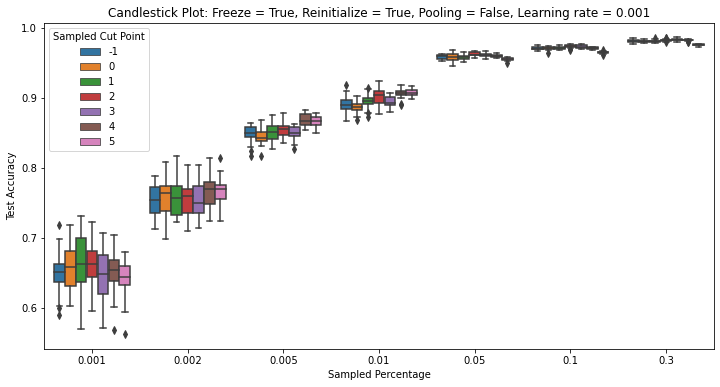

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining both datasets for comparative analysis
# df_combined = pd.DataFrame(results)
df_combined = pd.DataFrame(results_baseline+results)

# Creating boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='sampled_percentage', y='test_acc', hue='sampled_cut_point', data=df_combined)
plt.title(f'Candlestick Plot: Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
plt.xlabel('Sampled Percentage')
plt.ylabel('Test Accuracy')
plt.legend(title='Sampled Cut Point')
plt.show()

In [ ]:
#save results
with open(f'results_jsons/results_freeze_{params["freeze"]}_pool_{params["use_pooling"]}_lr_{params["lr_fine_tune"]}_dummy_run_MNIST.json', 'w') as f:
    json.dump(results, f)

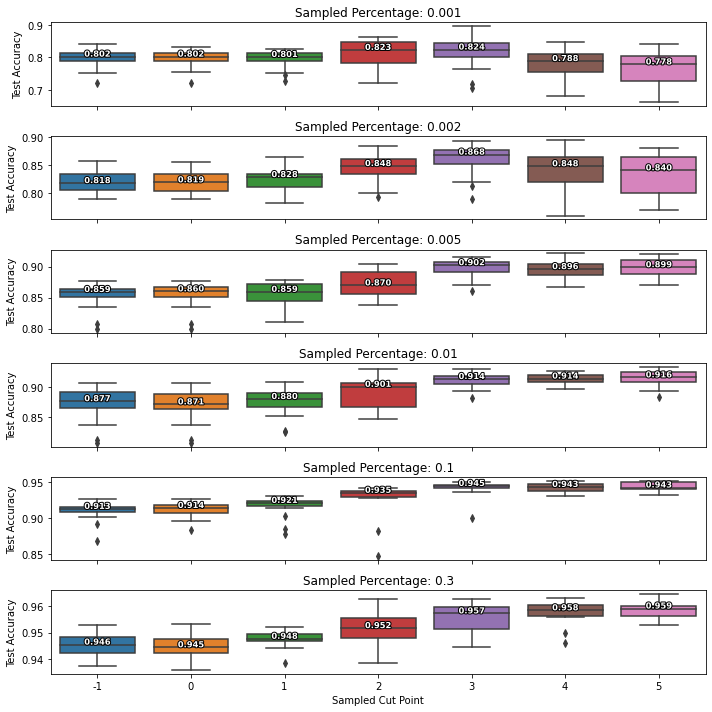

In [39]:
from matplotlib import patheffects
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import patheffects
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining the baseline and results data into a single DataFrame
df_combined = pd.DataFrame(results_baseline + results)

# Assuming 'percentages' is a list of unique percentages you want to consider
unique_percentages = df_combined['sampled_percentage'].unique()
unique_percentages = [perc for perc in unique_percentages if perc in percentages]

n_percentages = len(unique_percentages)

# Creating subplots for each data percentage
fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=(10, 10), sharex=True)

# Ensure axes is always an array
if n_percentages == 1:
    axes = [axes]

for i, percentage in enumerate(sorted(unique_percentages)):
    # Filtering data for each percentage
    df_subset = df_combined[df_combined['sampled_percentage'] == percentage]
    
    # Creating a boxplot for the current percentage
    sns.boxplot(x='sampled_cut_point', y='test_acc', data=df_subset, ax=axes[i])
    axes[i].set_title(f'Sampled Percentage: {percentage}')
    axes[i].set_xlabel('Sampled Cut Point' if i == n_percentages - 1 else '')
    axes[i].set_ylabel('Test Accuracy')

    # Annotating each boxplot with the median value
    medians = df_subset.groupby(['sampled_cut_point'])['test_acc'].median().sort_index()
    for j, median in enumerate(medians):
        text = axes[i].text(j, median, f'{median:.3f}', 
                            horizontalalignment='center', size='small', color='white', weight='semibold')
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])

plt.tight_layout()
plt.show()


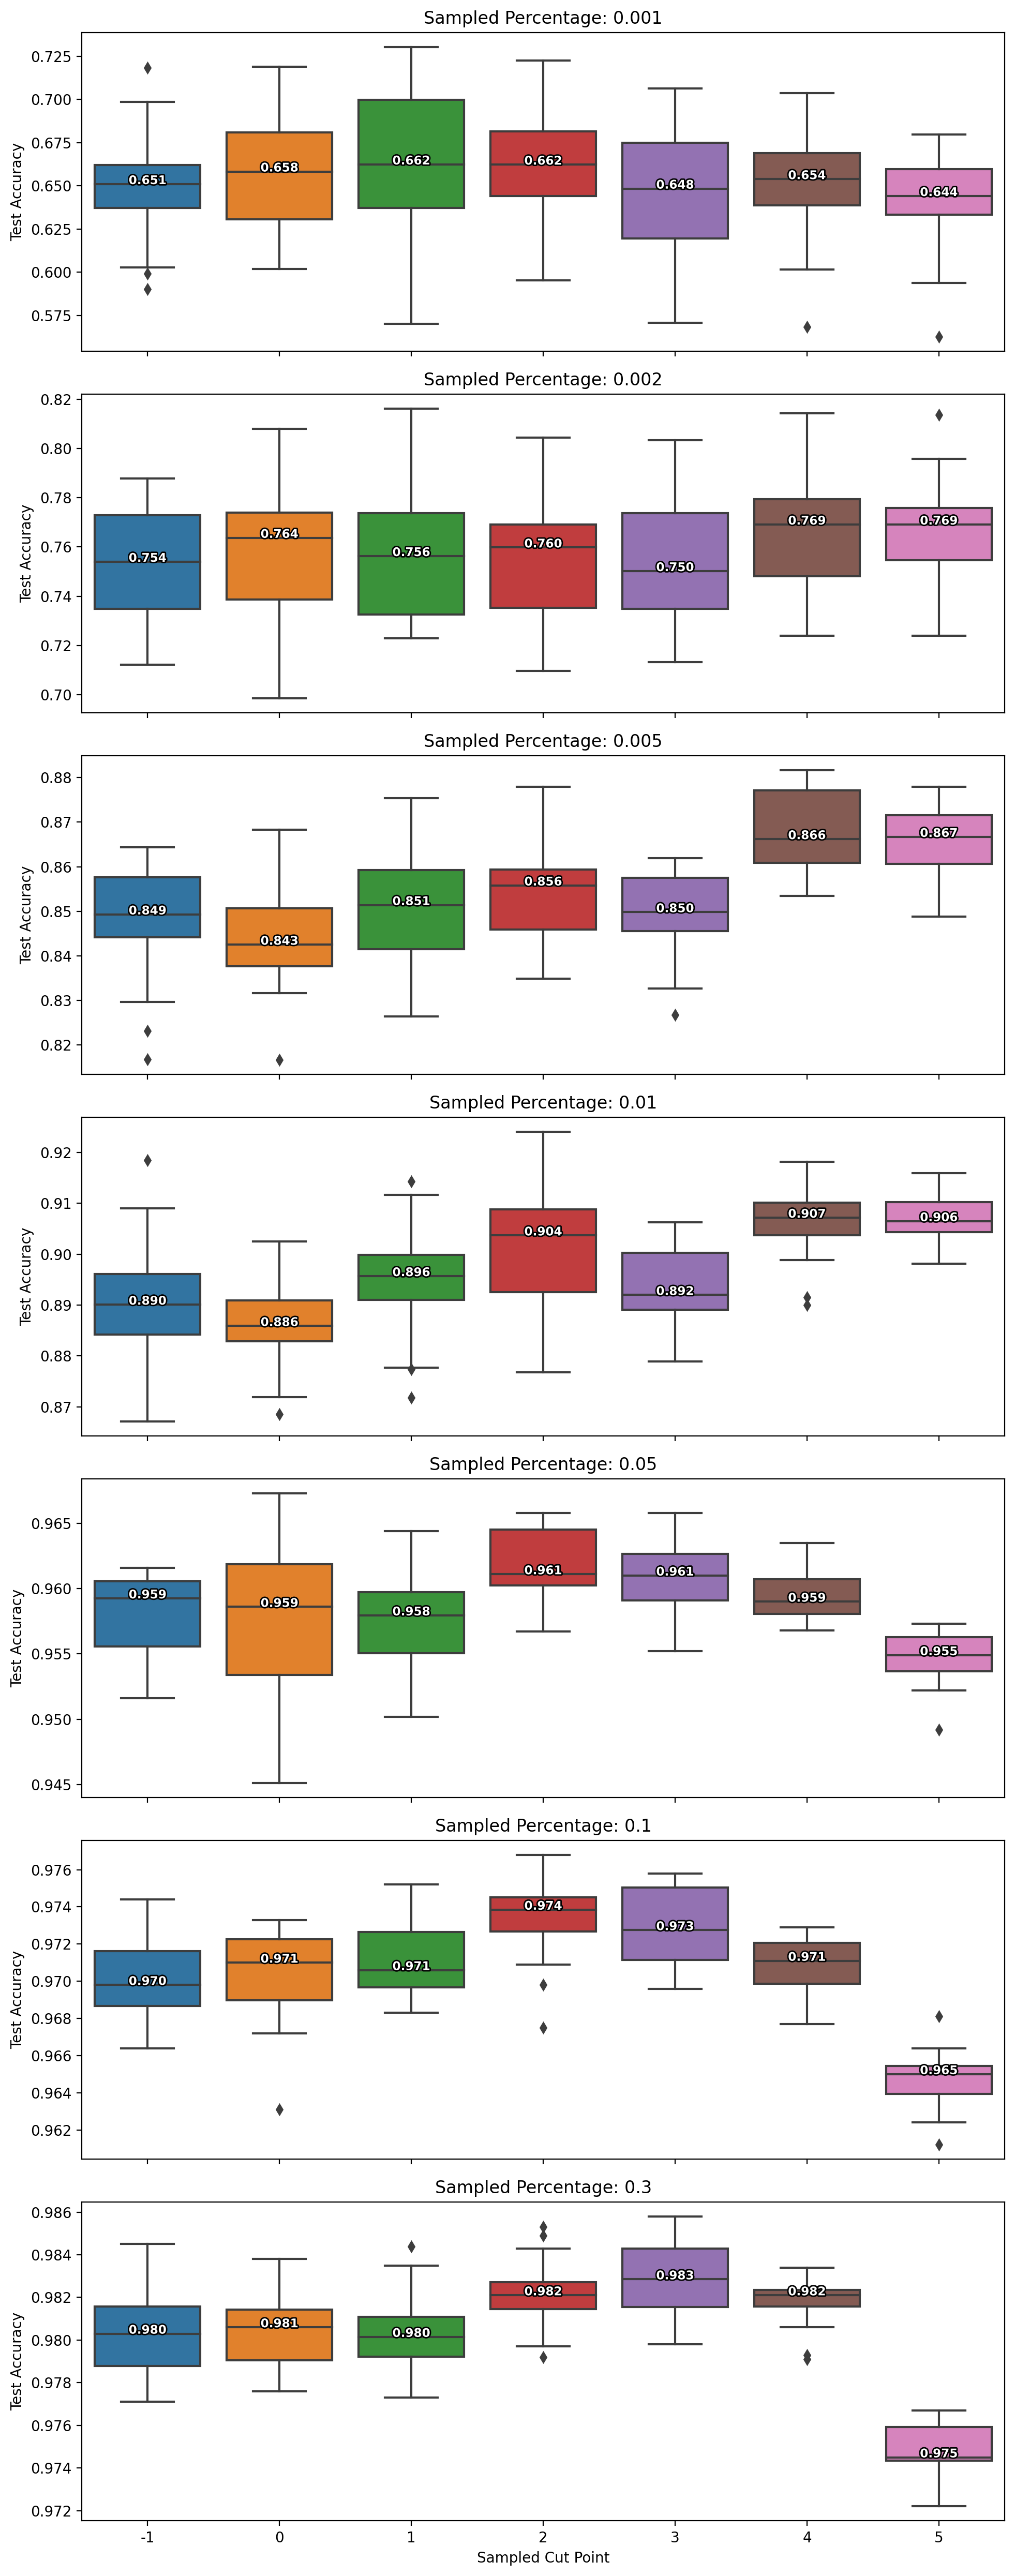

In [51]:
from matplotlib import patheffects
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import patheffects
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combining the baseline and results data into a single DataFrame
df_combined = pd.DataFrame(results_baseline + results)

# Assuming 'percentages' is a list of unique percentages you want to consider
unique_percentages = df_combined['sampled_percentage'].unique()
#unique_percentages = [perc for perc in unique_percentages if perc in percentages]

n_percentages = len(unique_percentages)

# Creating subplots for each data percentage
fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=(10, 25), sharex=True,  dpi=200)

# Ensure axes is always an array
if n_percentages == 1:
    axes = [axes]

for i, percentage in enumerate(sorted(unique_percentages)):
    # Filtering data for each percentage
    df_subset = df_combined[df_combined['sampled_percentage'] == percentage]
    
    # Creating a boxplot for the current percentage
    sns.boxplot(x='sampled_cut_point', y='test_acc', data=df_subset, ax=axes[i])
    axes[i].set_title(f'Sampled Percentage: {percentage}')
    axes[i].set_xlabel('Sampled Cut Point' if i == n_percentages - 1 else '')
    axes[i].set_ylabel('Test Accuracy')

    # Annotating each boxplot with the median value
    medians = df_subset.groupby(['sampled_cut_point'])['test_acc'].median().sort_index()
    for j, median in enumerate(medians):
        text = axes[i].text(j, median, f'{median:.3f}', 
                            horizontalalignment='center', size='small', color='white', weight='semibold')
        text.set_path_effects([patheffects.withStroke(linewidth=2, foreground="black")])

plt.tight_layout()
plt.show()


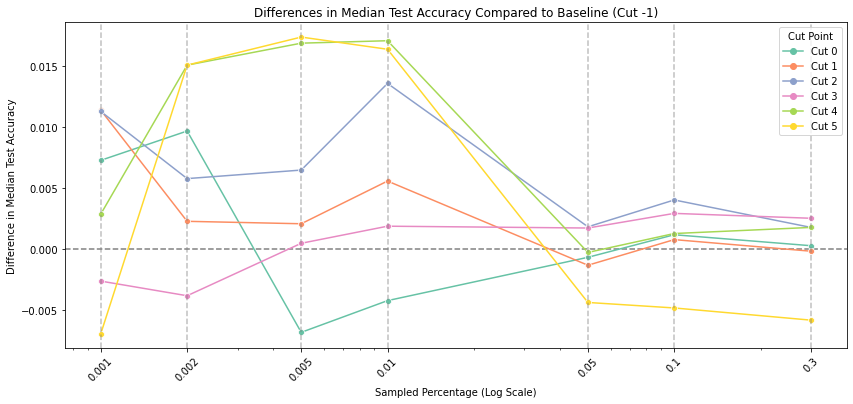

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_combined is your original DataFrame

# Grouping by sampled_percentage, sampled_cut_point and calculating medians
medians_by_cut = df_combined.groupby(['sampled_percentage', 'sampled_cut_point'])['test_acc'].median().reset_index()

# Pivoting the table for easier calculation of differences
pivot_medians = medians_by_cut.pivot(index='sampled_percentage', columns='sampled_cut_point', values='test_acc')

# Identifying all unique cut points except for the baseline (-1)
cut_points = [col for col in pivot_medians.columns if col != -1]

# Calculating differences from baseline for each cut point
for cut in cut_points:
    pivot_medians[f'diff_cut_{cut}'] = pivot_medians[cut] - pivot_medians[-1]

# Resetting index to make 'sampled_percentage' a column
pivot_medians.reset_index(inplace=True)

# Removing rows with NaN values in the new difference columns
pivot_medians.dropna(subset=[f'diff_cut_{cut}' for cut in cut_points], inplace=True)

# Plot setup
plt.figure(figsize=(14, 6))
palette = sns.color_palette("Set2", len(cut_points))  # Setting palette based on number of cut points
plt.title('Differences in Median Test Accuracy Compared to Baseline (Cut -1)')
plt.xlabel('Sampled Percentage (Log Scale)')
plt.ylabel('Difference in Median Test Accuracy')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at zero

# Plotting the differences for each cut
for i, cut in enumerate(cut_points):
    sns.lineplot(x='sampled_percentage', y=f'diff_cut_{cut}', data=pivot_medians, marker='o', color=palette[i])

# Adding vertical dashed lines for each sampled percentage
for percentage in pivot_medians['sampled_percentage'].unique():
    plt.axvline(percentage, color='gray', linestyle='--', alpha=0.5)

plt.xscale('log')
plt.xticks(pivot_medians['sampled_percentage'], labels=pivot_medians['sampled_percentage'], rotation=45)

# Custom legend
legend_labels = [f'Cut {cut}' for cut in cut_points]
plt.legend(title='Cut Point', labels=legend_labels, handles=[plt.Line2D([0], [0], color=palette[i], marker='o') for i in range(len(cut_points))])

plt.show()


In [57]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# Assuming df_combined is your original DataFrame
df_differences = df_combined[df_combined['sampled_cut_point'] != -1]
df_combined.sort_values(by=['sampled_percentage', 'sampled_cut_point'], inplace=True)

median_baseline = df_combined[df_combined['sampled_cut_point'] == -1].groupby('sampled_percentage')['test_acc'].median()
df_with_baseline = df_combined.merge(median_baseline, on='sampled_percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['test_acc'] - df_with_baseline['test_acc_baseline']
df_differences = df_with_baseline[df_with_baseline['sampled_cut_point'] != -1]

In [59]:
import pandas as pd
from scipy.stats import wilcoxon
import numpy as np

# Assuming df_combined is your original DataFrame
df_differences = df_combined[df_combined['sampled_cut_point'] != -1]


def perform_wilcoxon_test(group, cut_point_1, cut_point_2):
    data_1 = group[group['sampled_cut_point'] == cut_point_1]['test_acc']
    data_2 = group[group['sampled_cut_point'] == cut_point_2]['test_acc']

    # Ensure equal length by trimming or padding
    min_len = min(len(data_1), len(data_2))
    data_1, data_2 = data_1[:min_len], data_2[:min_len]

    stat, p_value = wilcoxon(data_1, data_2)
    return stat, p_value

# Perform pairwise comparison for each sampled_percentage
wilcoxon_pairwise_results = []

for percentage in df_differences['sampled_percentage'].unique():
    group = df_differences[df_differences['sampled_percentage'] == percentage]
    cut_points = group['sampled_cut_point'].unique()

    for i in range(len(cut_points)):
        for j in range(i + 1, len(cut_points)):
            stat, p_value = perform_wilcoxon_test(group, cut_points[i], cut_points[j])
            wilcoxon_pairwise_results.append({
                'sampled_percentage': percentage,
                'cut_point_1': cut_points[i],
                'cut_point_2': cut_points[j],
                'statistic': stat,
                'p_value': p_value
            })

# Converting the results to a DataFrame
df_wilcoxon_pairwise = pd.DataFrame(wilcoxon_pairwise_results)


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [61]:
import pandas as pd

# Assuming df_wilcoxon_pairwise and df_differences are defined as before

# Step 1: Aggregate Test Accuracy and Initialize Rankings
median_accuracy = df_differences.groupby(['sampled_percentage', 'sampled_cut_point'])['test_acc'].median()

rankings = {percentage: {} for percentage in median_accuracy.index.get_level_values(0).unique()}
for (percentage, cut_point), accuracy in median_accuracy.items():
    rankings[percentage][cut_point] = {'median_accuracy': accuracy, 'rank': None, 'group': set([cut_point])}

# Step 2: Group Cuts Based on Statistical Significance
alpha = 0.05  # Significance level

for percentage, cuts_info in rankings.items():
    for cut1, info1 in cuts_info.items():
        for cut2, info2 in cuts_info.items():
            if cut1 != cut2:
                wilcoxon_row = df_wilcoxon_pairwise[
                    (df_wilcoxon_pairwise['sampled_percentage'] == percentage) & 
                    ((df_wilcoxon_pairwise['cut_point_1'] == cut1) & (df_wilcoxon_pairwise['cut_point_2'] == cut2) |
                     (df_wilcoxon_pairwise['cut_point_1'] == cut2) & (df_wilcoxon_pairwise['cut_point_2'] == cut1))
                ]
                if not wilcoxon_row.empty and wilcoxon_row.iloc[0]['p_value'] > alpha:
                    # Merge groups if not significantly different
                    info1['group'].update(info2['group'])
                    for cut in info2['group']:
                        info1['group'].update(rankings[percentage][cut]['group'])
                    for cut in info1['group']:
                        rankings[percentage][cut]['group'] = info1['group']

# Step 3: Assign Ranks with Ties
for percentage, cuts_info in rankings.items():
    sorted_groups = sorted({frozenset(info['group']) for cut, info in cuts_info.items()}, key=lambda x: min(median_accuracy[percentage, cut] for cut in x), reverse=True)
    rank = 1
    for group in sorted_groups:
        for cut in group:
            rankings[percentage][cut]['rank'] = rank
        rank += len(group)

# Convert rankings and median accuracies to a DataFrame for easier visualization
df_rankings = pd.DataFrame([(percentage, cut, data['rank'], data['median_accuracy']) for percentage, cuts_info in rankings.items() for cut, data in cuts_info.items()],
                           columns=['sampled_percentage', 'sampled_cut_point', 'rank', 'median_accuracy'])

df_rankings


,sampled_percentage,sampled_cut_point,rank,median_accuracy
0,0.001,0,3,0.802000
1,0.001,1,3,0.801000
2,0.001,2,1,0.822667
3,0.001,3,1,0.823667
4,0.001,4,3,0.788333
5,0.001,5,6,0.778000
6,0.002,0,2,0.819000
7,0.002,1,2,0.828333
8,0.002,2,2,0.848000
9,0.002,3,1,0.868333


In [62]:
median_baseline = df_combined[df_combined['sampled_cut_point'] == -1].groupby('sampled_percentage')['test_acc'].median()
df_with_baseline = df_combined.merge(median_baseline, on='sampled_percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['test_acc'] - df_with_baseline['test_acc_baseline']
df_differences = df_with_baseline[df_with_baseline['sampled_cut_point'] != -1]

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_test(data, baseline_median, cut_point):
    cut_data = data[data['sampled_cut_point'] == cut_point]['test_acc']
    baseline_data = np.full(len(cut_data), baseline_median)  # Creating an array of baseline values

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_data)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['sampled_percentage'].unique():
    baseline_median = median_baseline[percentage]
    for cut_point in df_differences[df_differences['sampled_cut_point'] != -1]['sampled_cut_point'].unique():
        subset = df_differences[(df_differences['sampled_percentage'] == percentage) & (df_differences['sampled_cut_point'] == cut_point)]
        stat, p_value = perform_wilcoxon_test(subset, baseline_median, cut_point)
        wilcoxon_corrected_results.append({
            'sampled_percentage': percentage,
            'sampled_cut_point': cut_point,
            'statistic': stat,
            'p_value': p_value
        })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [63]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
df_wilcoxon_corrected

,sampled_percentage,sampled_cut_point,statistic,p_value,is_significant
0,0.001,0,129.0,5.484858e-01,False
1,0.001,1,126.0,4.928933e-01,False
2,0.001,2,117.0,2.303613e-01,False
3,0.001,3,97.0,8.019584e-02,False
4,0.001,4,75.0,1.731235e-02,True
5,0.001,5,57.5,3.419220e-03,True
6,0.002,0,145.5,6.720752e-01,False
7,0.002,1,99.5,9.573346e-02,False
8,0.002,2,18.5,1.829863e-05,True
9,0.002,3,7.0,1.132488e-06,True


----

In [68]:
#load results
with open('/home/arnisaf/mp-tl-study/FashionMNIST/results_jsons/results_freeze_True_reinit_False_pool_False_truncate_True_lr_0.001.json', 'r') as f:
    truncated = json.load(f)

In [74]:
truncated[1:]

[{'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 0,
  'train_acc': 1.0,
  'test_acc': 0.798},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 1,
  'train_acc': 0.9333333333333333,
  'test_acc': 0.803},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 2,
  'train_acc': 0.9333333333333333,
  'test_acc': 0.8046666666666666},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 3,
  'train_acc': 0.8,
  'test_acc': 0.805},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 4,
  'train_acc': 1.0,
  'test_acc': 0.82},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 5,
  'train_acc': 0.9333333333333333,
  'test_acc': 0.8093333333333333},
 {'lr': 0.001,
  'sampled_percentage': 0.001,
  'sampled_cut_point': 0,
  'repeat': 6,
  'train_acc': 1.0,
  'test_acc': 0.795},
 {'lr': 0.001,
  'sampled_p

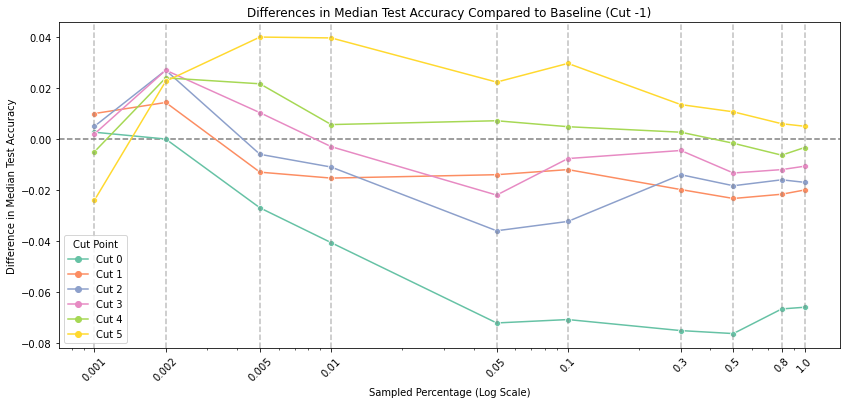

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converting the list of dictionaries to a DataFrame
df_combined = pd.DataFrame(results_baseline + truncated[1:])

# Grouping by sampled_percentage, sampled_cut_point and calculating medians
medians_by_cut = df_combined.groupby(['sampled_percentage', 'sampled_cut_point'])['test_acc'].median().reset_index()

# Pivoting the table for easier calculation of differences
pivot_medians = medians_by_cut.pivot(index='sampled_percentage', columns='sampled_cut_point', values='test_acc')

# Identifying all unique cut points except for the baseline (-1)
cut_points = [col for col in pivot_medians.columns if col != -1]

# Calculating differences from baseline for each cut point
for cut in cut_points:
    pivot_medians[f'diff_cut_{cut}'] = pivot_medians[cut] - pivot_medians[-1]

# Resetting index to make 'sampled_percentage' a column
pivot_medians.reset_index(inplace=True)

# Removing rows with NaN values in the new difference columns
pivot_medians.dropna(subset=[f'diff_cut_{cut}' for cut in cut_points], inplace=True)

# Plot setup
plt.figure(figsize=(14, 6))
palette = sns.color_palette("Set2", len(cut_points))  # Setting palette based on number of cut points
plt.title('Differences in Median Test Accuracy Compared to Baseline (Cut -1)')
plt.xlabel('Sampled Percentage (Log Scale)')
plt.ylabel('Difference in Median Test Accuracy')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at zero

# Plotting the differences for each cut
for i, cut in enumerate(cut_points):
    sns.lineplot(x='sampled_percentage', y=f'diff_cut_{cut}', data=pivot_medians, marker='o', color=palette[i])

# Adding vertical dashed lines for each sampled percentage
for percentage in pivot_medians['sampled_percentage'].unique():
    plt.axvline(percentage, color='gray', linestyle='--', alpha=0.5)

plt.xscale('log')
plt.xticks(pivot_medians['sampled_percentage'], labels=pivot_medians['sampled_percentage'], rotation=45)

# Custom legend
legend_labels = [f'Cut {cut}' for cut in cut_points]
plt.legend(title='Cut Point', labels=legend_labels, handles=[plt.Line2D([0], [0], color=palette[i], marker='o') for i in range(len(cut_points))])

plt.show()

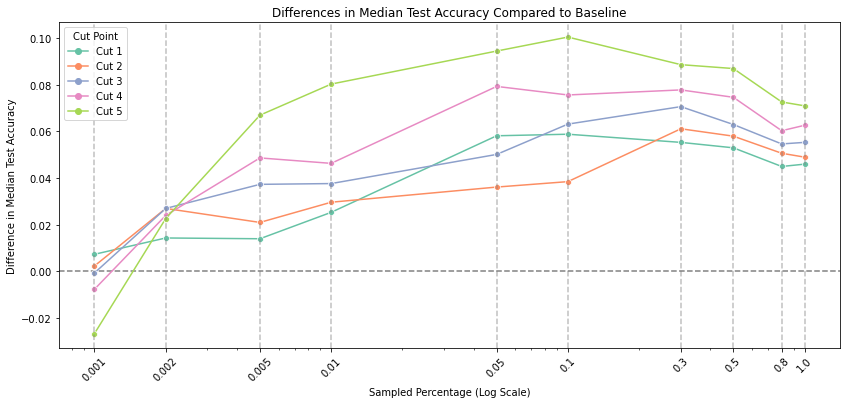

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converting the list of dictionaries to a DataFrame
df_combined = pd.DataFrame(truncated[1:])

# Grouping by sampled_percentage, sampled_cut_point and calculating medians
medians_by_cut = df_combined.groupby(['sampled_percentage', 'sampled_cut_point'])['test_acc'].median().reset_index()

# Pivoting the table for easier calculation of differences
pivot_medians = medians_by_cut.pivot(index='sampled_percentage', columns='sampled_cut_point', values='test_acc')

# Check if a baseline (-1) exists, if not choose an alternative or skip baseline comparison
baseline_cut = -1 if -1 in pivot_medians.columns else pivot_medians.columns[0]

# Identifying all unique cut points except for the baseline
cut_points = [col for col in pivot_medians.columns if col != baseline_cut]

# Calculating differences from baseline for each cut point
for cut in cut_points:
    pivot_medians[f'diff_cut_{cut}'] = pivot_medians[cut] - pivot_medians[baseline_cut]

# Resetting index to make 'sampled_percentage' a column
pivot_medians.reset_index(inplace=True)

# Removing rows with NaN values in the new difference columns
pivot_medians.dropna(subset=[f'diff_cut_{cut}' for cut in cut_points], inplace=True)

# Plot setup
plt.figure(figsize=(14, 6))
palette = sns.color_palette("Set2", len(cut_points))  # Setting palette based on number of cut points
plt.title('Differences in Median Test Accuracy Compared to Baseline')
plt.xlabel('Sampled Percentage (Log Scale)')
plt.ylabel('Difference in Median Test Accuracy')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at zero

# Plotting the differences for each cut
for i, cut in enumerate(cut_points):
    sns.lineplot(x='sampled_percentage', y=f'diff_cut_{cut}', data=pivot_medians, marker='o', color=palette[i])

# Adding vertical dashed lines for each sampled percentage
for percentage in pivot_medians['sampled_percentage'].unique():
    plt.axvline(percentage, color='gray', linestyle='--', alpha=0.5)

plt.xscale('log')
plt.xticks(pivot_medians['sampled_percentage'], labels=pivot_medians['sampled_percentage'], rotation=45)

# Custom legend
legend_labels = [f'Cut {cut}' for cut in cut_points]
plt.legend(title='Cut Point', labels=legend_labels, handles=[plt.Line2D([0], [0], color=palette[i], marker='o') for i in range(len(cut_points))])

plt.show()


---

In [80]:
#load results
with open('/home/arnisaf/mp-tl-study/FashionMNIST/results_jsons/ari/ari_scores_finetuned.json', 'r') as f:
    ari_scores_finetuned = json.load(f)

In [81]:
ari_scores_finetuned

[{'Percentage': 0.001,
  'Repeat': 0,
  'Num Samples': 0,
  'Layer': 'conv0',
  'Max ARI Score': 51.48514851485149,
  'Avg ARI Score': 26.989158177107402,
  'Dataset': 'Finetune',
  'Split': 'Train'},
 {'Percentage': 0.001,
  'Repeat': 0,
  'Num Samples': 0,
  'Layer': 'conv1',
  'Max ARI Score': 44.07713498622589,
  'Avg ARI Score': 23.97541889868459,
  'Dataset': 'Finetune',
  'Split': 'Train'},
 {'Percentage': 0.001,
  'Repeat': 0,
  'Num Samples': 0,
  'Layer': 'conv2',
  'Max ARI Score': 39.21568627450981,
  'Avg ARI Score': 23.47747113342892,
  'Dataset': 'Finetune',
  'Split': 'Train'},
 {'Percentage': 0.001,
  'Repeat': 0,
  'Num Samples': 0,
  'Layer': 'conv3',
  'Max ARI Score': 44.07713498622589,
  'Avg ARI Score': 23.552360449066324,
  'Dataset': 'Finetune',
  'Split': 'Train'},
 {'Percentage': 0.001,
  'Repeat': 0,
  'Num Samples': 0,
  'Layer': 'conv4',
  'Max ARI Score': 79.20792079207921,
  'Avg ARI Score': 25.414973265802768,
  'Dataset': 'Finetune',
  'Split': 'Train'

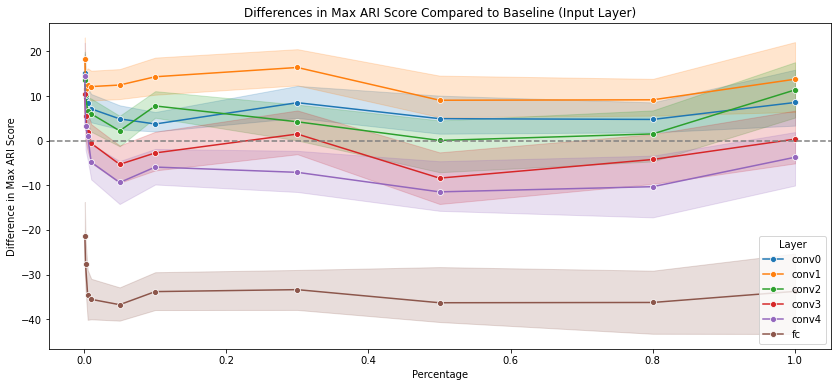

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to DataFrame
df_combined = pd.DataFrame(ari_scores_finetuned)

# Choose which score to use for comparison, e.g., 'Max ARI Score' or 'Avg ARI Score'
score_column = 'Max ARI Score'  # or 'Avg ARI Score'

# Group by and calculate median scores
medians_by_layer = df_combined.groupby(['Percentage', 'Repeat', 'Layer'])[score_column].median().reset_index()

# Pivot the table
pivot_medians = medians_by_layer.pivot_table(index=['Percentage', 'Repeat'], columns='Layer', values=score_column)

# Calculate differences from the baseline 'input' layer
for layer in pivot_medians.columns:
    if layer != 'input':
        pivot_medians[f'diff_{layer}'] = pivot_medians[layer] - pivot_medians['input']

# Reset index
pivot_medians.reset_index(inplace=True)

# Plot setup
plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(pivot_medians.columns) - 3)  # Excluding 'input', 'Percentage', 'Repeat'

# Plotting differences
for i, column in enumerate(pivot_medians.columns):
    if column.startswith('diff_'):
        sns.lineplot(x='Percentage', y=column, data=pivot_medians, marker='o', palette=palette[i-3])

plt.title('Differences in ' + score_column + ' Compared to Baseline (Input Layer)')
plt.xlabel('Percentage')
plt.ylabel('Difference in ' + score_column)
plt.axhline(0, color='gray', linestyle='--')  # Reference line at zero

# Custom legend
legend_labels = [col.replace('diff_', '') for col in pivot_medians.columns if col.startswith('diff_')]
plt.legend(title='Layer', labels=legend_labels)

plt.show()
